In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('energy_price',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/alexanderdahm/Documents/GitHub/mlfs-book-proj
HopsworksSettings initialized!


### <span style='color:#ff5f27'> 📝 Imports

In [2]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.energy_price import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()

2025-12-28 19:24:23,931 INFO: Initializing external client
2025-12-28 19:24:23,931 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-12-28 19:24:25,468 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1290388


In [4]:
# Retrieve feature groups
energy_price_fg = fs.get_feature_group(
    name='energy_price',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

In [5]:
"""weather_df = weather_fg.read()

# Check the first date to see the 5 duplicates
print(weather_df[weather_df['date'] == '2025-05-01'])"""

"weather_df = weather_fg.read()\n\n# Check the first date to see the 5 duplicates\nprint(weather_df[weather_df['date'] == '2025-05-01'])"

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [6]:
# Select features for training data. Added pm25_roll3 feature
selected_features = energy_price_fg.select(['sek', 'date']).join(weather_fg.select_features(), on=['date'])

2025-12-28 19:24:27,361 INFO: Using ['temperature_2m_mean_flasjon', 'precipitation_sum_flasjon', 'wind_speed_10m_max_flasjon', 'wind_direction_10m_dominant_flasjon', 'temperature_2m_mean_hudiksvall', 'precipitation_sum_hudiksvall', 'wind_speed_10m_max_hudiksvall', 'wind_direction_10m_dominant_hudiksvall', 'temperature_2m_mean_ange', 'precipitation_sum_ange', 'wind_speed_10m_max_ange', 'wind_direction_10m_dominant_ange', 'temperature_2m_mean_solleftea', 'precipitation_sum_solleftea', 'wind_speed_10m_max_solleftea', 'wind_direction_10m_dominant_solleftea', 'temperature_2m_mean_umea', 'precipitation_sum_umea', 'wind_speed_10m_max_umea', 'wind_direction_10m_dominant_umea'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [7]:
feature_view = fs.get_or_create_feature_view(
    name='energy_price_fv',
    description="Weather feutures with energy price as label",
    version=1,
    labels=['sek'],
    query=selected_features,
)

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [8]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [9]:
"""print("Starting Spark job to create training data...")
version, job = feature_view.create_train_test_split(
    test_start=test_start,
    description="Fresh Hudi split",
    data_format="parquet",
    write_options={"wait_for_job": True}
)

print(f"Success! Training dataset version {version} created.")
"""

# 6. Read the data
X_train, X_test, y_train, y_test = feature_view.get_train_test_split(
    training_dataset_version=1
)

In [10]:
X_train

,date,temperature_2m_mean_flasjon,precipitation_sum_flasjon,wind_speed_10m_max_flasjon,wind_direction_10m_dominant_flasjon,temperature_2m_mean_hudiksvall,precipitation_sum_hudiksvall,wind_speed_10m_max_hudiksvall,wind_direction_10m_dominant_hudiksvall,temperature_2m_mean_ange,...,wind_speed_10m_max_ange,wind_direction_10m_dominant_ange,temperature_2m_mean_solleftea,precipitation_sum_solleftea,wind_speed_10m_max_solleftea,wind_direction_10m_dominant_solleftea,temperature_2m_mean_umea,precipitation_sum_umea,wind_speed_10m_max_umea,wind_direction_10m_dominant_umea
0,2023-07-17,14.723166,6.0,19.681828,227.607162,17.543749,0.7,23.166216,219.352509,16.248667,...,21.986542,215.208771,16.912498,5.2,20.377399,207.789612,16.727085,1.4,24.675106,198.073929
1,2025-02-15,-10.585168,0.7,16.454992,345.313812,-8.387501,0.7,20.138292,342.736908,-9.426332,...,16.419512,343.730591,-10.120832,0.0,14.275713,312.907776,-8.520833,0.1,18.175545,343.177826
2,2023-02-15,-4.851833,0.0,11.966954,257.495178,-3.937500,0.0,11.753876,249.007050,-7.040916,...,7.993298,243.671738,-3.666667,0.0,7.091177,172.130997,-0.675000,0.0,14.417988,218.927490
3,2023-11-07,-1.445583,0.0,6.379216,257.496552,2.039583,0.0,5.588703,308.088806,-0.940917,...,5.154415,283.293152,0.047917,0.0,6.297428,293.678589,1.329167,0.9,11.901798,357.519135
4,2024-02-06,-8.939333,0.7,8.669949,126.627998,-12.810416,0.0,14.182355,320.859833,-13.813831,...,5.991594,48.077526,-13.010418,0.0,9.339208,293.672882,-10.741666,0.0,11.090103,5.531597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,2024-04-03,-10.956000,0.0,10.799999,9.188781,-6.960417,0.0,17.414476,350.386902,-9.113832,...,12.620554,350.805969,-8.912499,0.0,13.779114,330.223755,-8.270834,0.0,22.264771,3.089272
847,2024-04-16,-0.768500,0.2,9.957108,286.440521,2.379167,1.8,11.988594,32.625370,2.969500,...,11.720751,1.525937,2.545833,0.1,14.934577,344.931427,1.310417,0.1,14.934577,0.149381
848,2024-05-27,16.450249,0.5,18.057508,180.076660,16.691666,0.2,13.905509,164.123993,18.252834,...,17.026896,166.833633,18.304165,0.3,18.079027,155.316284,16.208336,0.0,13.202726,198.794662
849,2024-10-23,6.133584,2.4,24.503809,257.543274,8.939584,0.1,19.840050,260.918304,7.400750,...,19.200188,242.433212,7.335417,0.4,21.986542,256.249329,6.645834,2.6,22.158285,260.137665


In [11]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

In [12]:
y_train

,sek
0,56.990002
1,85.339996
2,869.690002
3,971.869995
4,690.059998
...,...
846,527.530029
847,489.970001
848,28.610001
849,3.170000


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>


In [13]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 61848.023
R squared: 0.19991229850930592


In [15]:
df = y_test
df['predicted_sek'] = y_pred

In [16]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,sek,predicted_sek,date
151,47.840000,79.911011,2025-05-01
69,14.530000,57.524426,2025-05-02
9,10.460000,59.204704,2025-05-03
101,14.280000,267.637329,2025-05-04
232,95.269997,78.459976,2025-05-05


In [17]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "energy_price_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

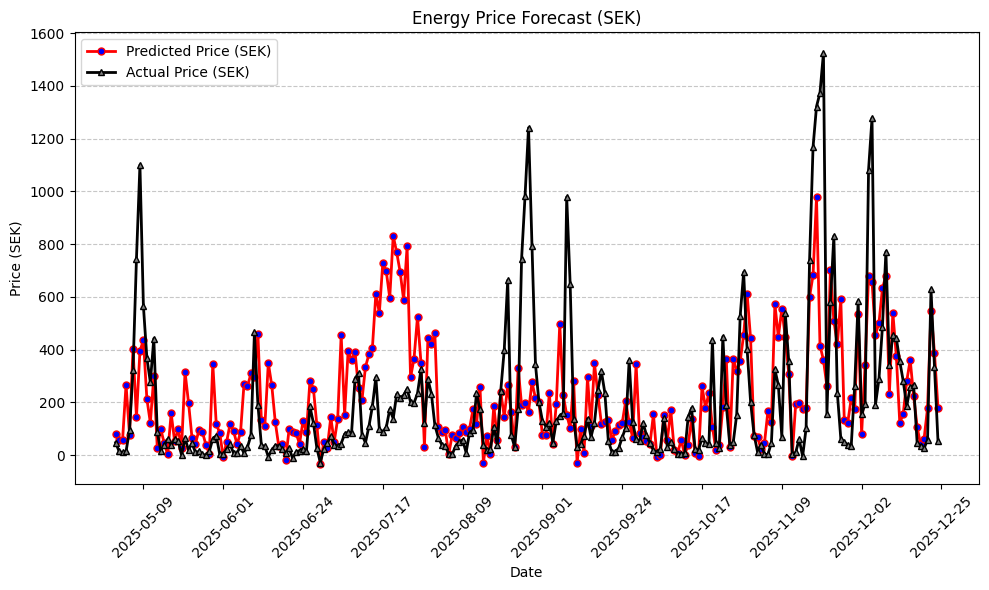

In [20]:
file_path = images_dir + "/energy_price_hindcast.png"
plt = util.plot_energy_forecast(df, file_path, hindcast=True) 
plt.show()

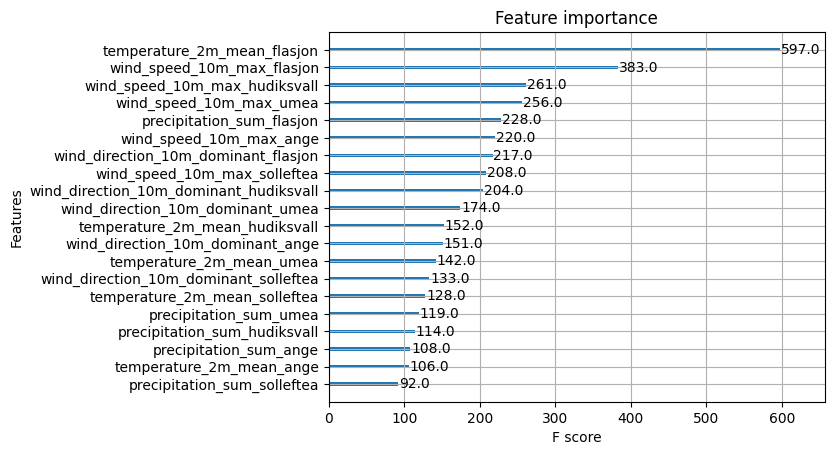

In [21]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

In [22]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model_energy_price.json")

In [23]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [24]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="energy_price_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Energy Price Predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/alexanderdahm/Documents/GitHub/mlfs-book-proj/notebooks/airquality/energy_price_model/model_e…

Uploading /Users/alexanderdahm/Documents/GitHub/mlfs-book-proj/notebooks/airquality/energy_price_model/images/…

Uploading /Users/alexanderdahm/Documents/GitHub/mlfs-book-proj/notebooks/airquality/energy_price_model/images/…

Uploading /Users/alexanderdahm/Documents/GitHub/mlfs-book-proj/notebooks/airquality/model_schema.json: 0.000%|…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1290388/models/energy_price_xgboost_model/1


Model(name: 'energy_price_xgboost_model', version: 1)